<a href="https://www.kaggle.com/code/shivamkumar090/hr-data?scriptVersionId=280338100" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
#Importing Libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
                             confusion_matrix, classification_report, roc_curve, precision_recall_curve, auc)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

try:
    from xgboost import XGBClassifier
    xgb_available = True
except Exception:
    xgb_available = False

import joblib
import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/hr-analytics-job-change-of-data-scientists/sample_submission.csv
/kaggle/input/hr-analytics-job-change-of-data-scientists/aug_test.csv
/kaggle/input/hr-analytics-job-change-of-data-scientists/aug_train.csv


**Loading the Dataset**

In [2]:
#Dataset Loading
train=pd.read_csv('/kaggle/input/hr-analytics-job-change-of-data-scientists/aug_train.csv')
val=pd.read_csv('/kaggle/input/hr-analytics-job-change-of-data-scientists/aug_test.csv')
sample=pd.read_csv('/kaggle/input/hr-analytics-job-change-of-data-scientists/sample_submission.csv')

 **Exploratory Data Analysis (EDA)**

In [3]:
#Data Shape
print("Train Shape:",train.shape)
print("Test Shape:",val.shape)

Train Shape: (19158, 14)
Test Shape: (2129, 13)


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

In [5]:
train.head(3)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0


In [6]:
#Target Column Distribution
train['target'] = train['target'].astype(int)
train['target'].value_counts(normalize=True)

target
0    0.750652
1    0.249348
Name: proportion, dtype: float64

In [7]:
#Five Number Summary 
display(train.describe(include='all').T)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
enrollee_id,19158.0,NaN,NaN,NaN,16875.358179,9616.292592,1.0,8554.25,16982.5,25169.75,33380.0
city,19158,123,city_103,4355,NaN,NaN,NaN,NaN,NaN,NaN,NaN
city_development_index,19158.0,NaN,NaN,NaN,0.828848,0.123362,0.448,0.74,0.903,0.92,0.949
gender,14650,3,Male,13221,NaN,NaN,NaN,NaN,NaN,NaN,NaN
relevent_experience,19158,2,Has relevent experience,13792,NaN,NaN,NaN,NaN,NaN,NaN,NaN
enrolled_university,18772,3,no_enrollment,13817,NaN,NaN,NaN,NaN,NaN,NaN,NaN
education_level,18698,5,Graduate,11598,NaN,NaN,NaN,NaN,NaN,NaN,NaN
major_discipline,16345,6,STEM,14492,NaN,NaN,NaN,NaN,NaN,NaN,NaN
experience,19093,22,>20,3286,NaN,NaN,NaN,NaN,NaN,NaN,NaN
company_size,13220,8,50-99,3083,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
#Percentage of Null Value in each Column
null_val=train.isnull().sum()
print("No of Columns having null values:",null_val[null_val>0].shape[0])
print("Columns:\n",null_val[null_val>0]/len(train)*100)

No of Columns having null values: 8
Columns:
 gender                 23.530640
enrolled_university     2.014824
education_level         2.401086
major_discipline       14.683161
experience              0.339284
company_size           30.994885
company_type           32.049274
last_new_job            2.207955
dtype: float64


In [9]:
print("No of Duplicate entries:",train.duplicated().sum())

No of Duplicate entries: 0


In [10]:
#Unique Value of Each Column
for i in train.columns:
    print(i,":",train[i].unique(),"\n")

enrollee_id : [ 8949 29725 11561 ... 24576  5756 23834] 

city : ['city_103' 'city_40' 'city_21' 'city_115' 'city_162' 'city_176'
 'city_160' 'city_46' 'city_61' 'city_114' 'city_13' 'city_159' 'city_102'
 'city_67' 'city_100' 'city_16' 'city_71' 'city_104' 'city_64' 'city_101'
 'city_83' 'city_105' 'city_73' 'city_75' 'city_41' 'city_11' 'city_93'
 'city_90' 'city_36' 'city_20' 'city_57' 'city_152' 'city_19' 'city_65'
 'city_74' 'city_173' 'city_136' 'city_98' 'city_97' 'city_50' 'city_138'
 'city_82' 'city_157' 'city_89' 'city_150' 'city_70' 'city_175' 'city_94'
 'city_28' 'city_59' 'city_165' 'city_145' 'city_142' 'city_26' 'city_12'
 'city_37' 'city_43' 'city_116' 'city_23' 'city_99' 'city_149' 'city_10'
 'city_45' 'city_80' 'city_128' 'city_158' 'city_123' 'city_7' 'city_72'
 'city_106' 'city_143' 'city_78' 'city_109' 'city_24' 'city_134' 'city_48'
 'city_144' 'city_91' 'city_146' 'city_133' 'city_126' 'city_118' 'city_9'
 'city_167' 'city_27' 'city_84' 'city_54' 'city_39' 'city_7

In [11]:
#Converting Experience Column to float Value 
def experience_to_numeric(exp):
    if exp == '<1':
        return 0.5
    elif exp == '>20':
        return 21
    elif pd.isna(exp):
        return np.nan
    else:
        return float(exp)

train['experience'] = train['experience'].apply(experience_to_numeric)


In [12]:
#Mapping to integer value for column "last_new_job"
mapping = {'never': 0, '1': 1, '2': 2, '3': 3, '4': 4, '>4': 5}
train['last_new_job'] = train['last_new_job'].map(mapping)
train['last_new_job'] = train['last_new_job'].fillna(np.nan) 

In [13]:
#Mapping of Company Size to mid point Value 
size_midpoint_map = {
    '<10': 5,
    '10/49': 29.5,
    '50-99': 74.5,
    '100-500': 300,
    '500-999': 750,
    '1000-4999': 2999.5,
    '5000-9999': 7499.5,
    '10000+': 10000
}

train['company_size'] = train['company_size'].map(size_midpoint_map)
train['company_size'] = train['company_size'].fillna(np.nan) 


In [14]:
#Mapping 
train['city_development_index']=train['city_development_index'].astype(float)
train['relevent_experience_bin'] = train['relevent_experience'].map({'Has relevent experience':1, 'No relevent experience':0})


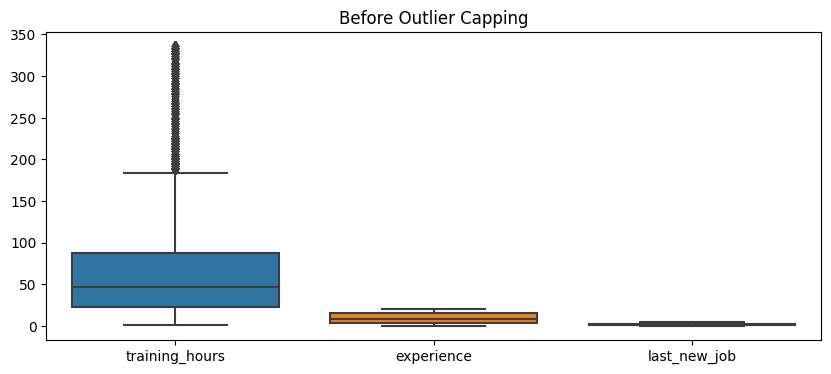

In [15]:
#Box PLot for checking outliers
plt.figure(figsize=(10,4))
sns.boxplot(data=train[['training_hours','experience','last_new_job',]])
plt.title("Before Outlier Capping")
plt.show()

In [16]:
#Function for finding outliers
def cap_outliers_iqr(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    df[col] = np.where(df[col] < lower, lower,
                       np.where(df[col] > upper, upper, df[col]))
    return df

In [17]:
outlier_cols = ['training_hours', 'experience','last_new_job']

for col in outlier_cols:
    train = cap_outliers_iqr(train, col)

train[outlier_cols].describe()

,training_hours,experience,last_new_job
count,19158.000000,19093.000000,18735.000000
mean,62.176793,10.113811,2.000427
std,50.212703,6.757112,1.675596
min,1.000000,0.500000,0.000000
25%,23.000000,4.000000,1.000000
50%,47.000000,9.000000,1.000000
75%,88.000000,16.000000,3.000000
max,185.500000,21.000000,5.000000


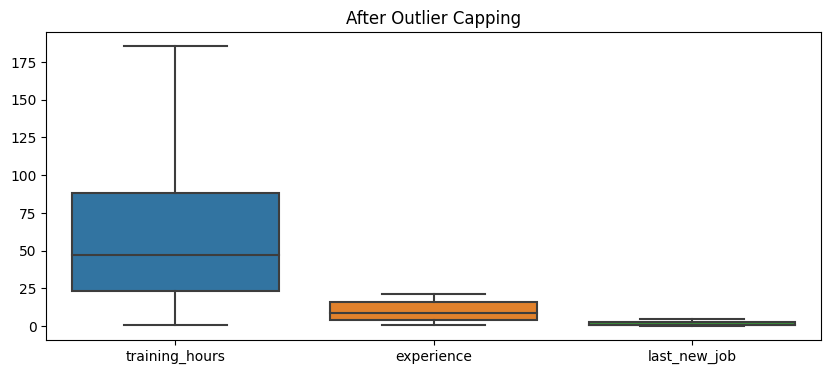

In [18]:
#Box Plot After removing Oultliers 
plt.figure(figsize=(10,4))
sns.boxplot(data=train[['training_hours','experience','last_new_job']])
plt.title("After Outlier Capping")
plt.show()

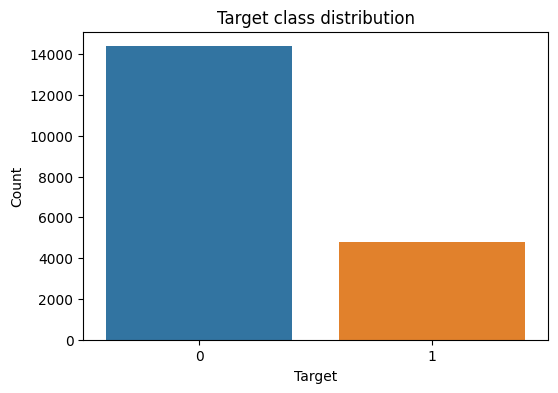

In [19]:
#Bar plot of target distribution
plt.figure(figsize=(6,4))
sns.countplot(x='target', data=train)
plt.title('Target class distribution')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

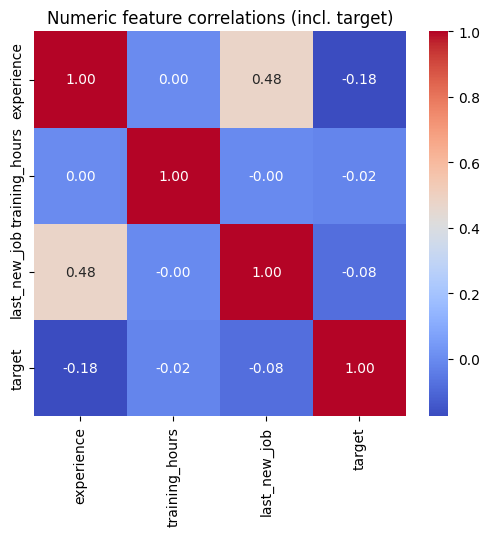

In [20]:
#Correlation Matrix of Numerical Columns
num_cols=['experience','training_hours','last_new_job']
plt.figure(figsize=(6,5))
sns.heatmap(train[num_cols + ['target']].corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Numeric feature correlations (incl. target)')
plt.show()

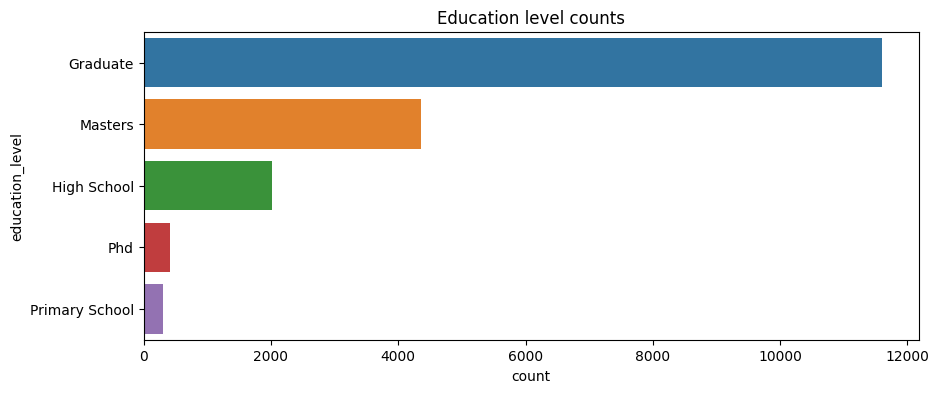

In [21]:
#Horizonatal Bar Plot of Count of Education Level
plt.figure(figsize=(10,4))
sns.countplot(y='education_level', data=train, order=train['education_level'].value_counts().index)
plt.title('Education level counts')
plt.show()

<Axes: xlabel='training_hours', ylabel='Count'>

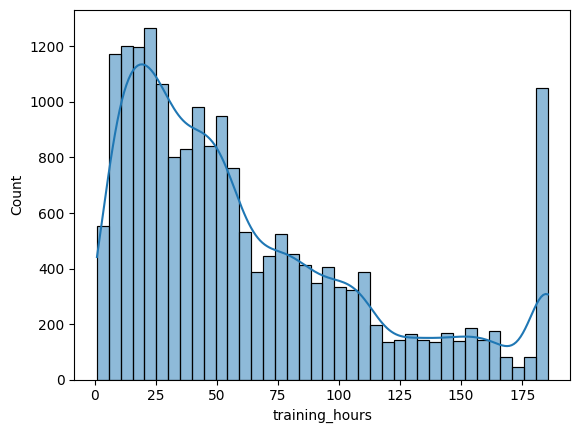

In [22]:
#Histogram for Training Hours
sns.histplot(train['training_hours'],kde=True)

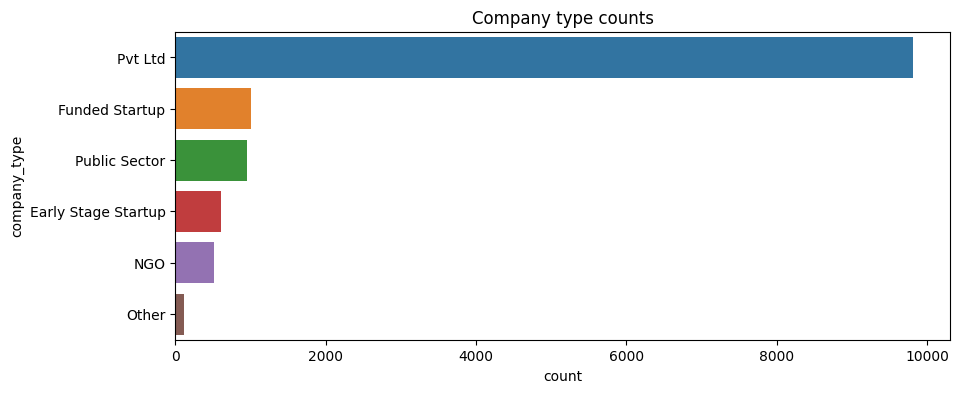

In [23]:
#Horizontal Bar Plot fo Count Company type
plt.figure(figsize=(10,4))
sns.countplot(y='company_type', data=train, order=train['company_type'].value_counts().index)
plt.title('Company type counts')
plt.show()

<Axes: xlabel='major_discipline'>

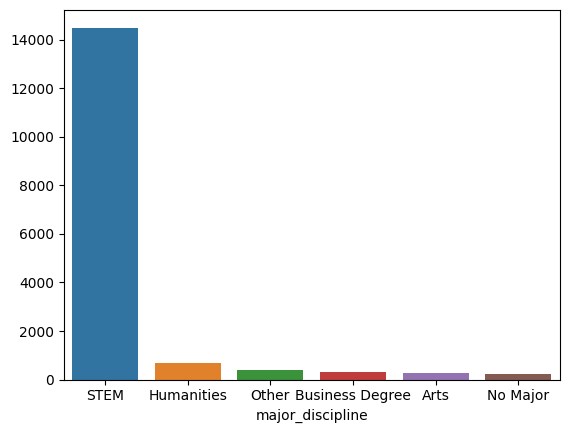

In [24]:
#Bar Plot of Count of Major Discipline
mj_company=train['major_discipline'].value_counts()
sns.barplot(x=mj_company.index,y=mj_company.values)

<Axes: xlabel='company_size'>

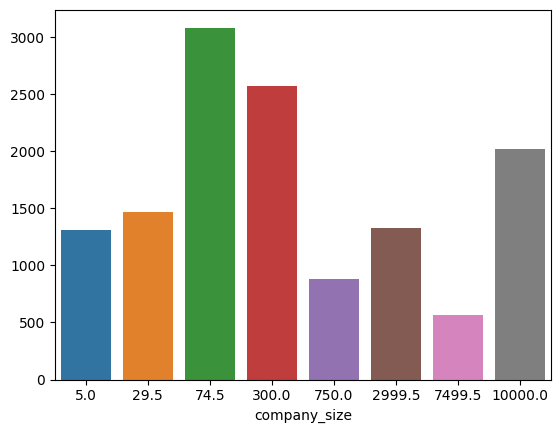

In [25]:
#Bar plot of Company Size
cs_company=train['company_size'].value_counts()
sns.barplot(x=cs_company.index,y=cs_company.values)

**Data Preprocessing**

In [26]:
#X and Y Split
X=train.drop(['target'],axis=1)
y=train['target']

In [27]:
#Fill Nan with most_frequent value
from sklearn.impute import SimpleImputer
si=SimpleImputer(strategy='most_frequent')
X=pd.DataFrame(si.fit_transform(X),columns=X.columns)


In [28]:
#Chisqure Testing
from scipy.stats import chi2_contingency
for i in X.columns:
    cross = pd.crosstab(X[i], y)
    chi2, p, _, _ = chi2_contingency(cross)
    print("Chi-square p-value:" ,i, p)

Chi-square p-value: enrollee_id 0.49660320007391545
Chi-square p-value: city 0.0
Chi-square p-value: city_development_index 0.0
Chi-square p-value: gender 0.45675232710915714
Chi-square p-value: relevent_experience 1.5006628411178982e-70
Chi-square p-value: enrolled_university 2.267945402973493e-96
Chi-square p-value: education_level 1.168254108960399e-33
Chi-square p-value: major_discipline 0.12236179432062115
Chi-square p-value: experience 1.0660610956976657e-132
Chi-square p-value: company_size 7.971605523261e-124
Chi-square p-value: company_type 3.782006631159789e-18
Chi-square p-value: last_new_job 1.3204936717164661e-28
Chi-square p-value: training_hours 0.5039701433665454
Chi-square p-value: relevent_experience_bin 1.5006628411178982e-70


In [29]:
#Encoders 
from sklearn.preprocessing import OneHotEncoder,OrdinalEncoder
from category_encoders import TargetEncoder
education_order = ['Primary School', 'High School', 'Graduate', 'Masters', 'Phd']
oe = OrdinalEncoder(categories=[education_order], handle_unknown='use_encoded_value', unknown_value=-1)
X['education_level'] = oe.fit_transform(X[['education_level']])


In [30]:
on=OneHotEncoder()
X=on.fit_transform(X[['city','gender','relevent_experience','enrolled_university','major_discipline','company_type']])

In [31]:
#Train Test Split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)

**Model Training**

In [32]:
#Logistic Regression 
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression( )
lr.fit(X_train,y_train)

LogisticRegression()

In [33]:
#Predicton and Accuracy Score 
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix,accuracy_score,classification_report
y_pred=lr.predict(X_test)
print("Accuracy Score: ",accuracy_score(y_test,y_pred))

Accuracy Score:  0.7823590814196242


In [34]:
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.91      0.86      2877
           1       0.59      0.40      0.48       955

    accuracy                           0.78      3832
   macro avg       0.71      0.66      0.67      3832
weighted avg       0.76      0.78      0.77      3832



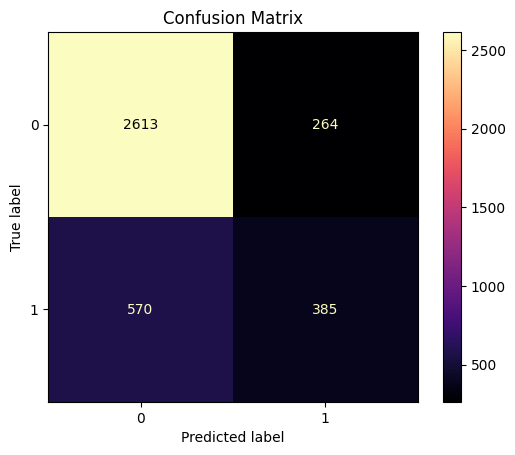

In [35]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='magma')
plt.title('Confusion Matrix')
plt.show()


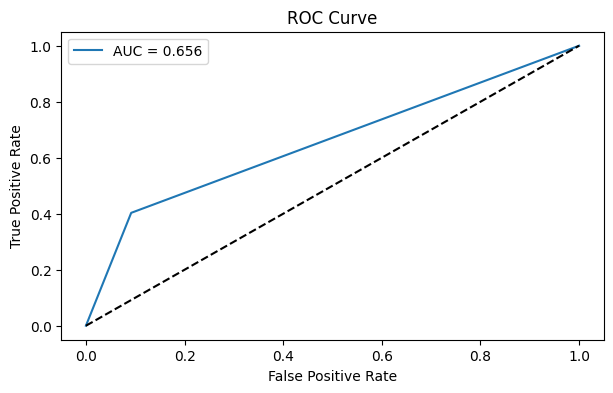

In [36]:
#Roc Curve
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred)

plt.figure(figsize=(7,4))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.3f}")
plt.plot([0,1], [0,1], 'k--') 
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

In [37]:
#SVC Model
from sklearn.svm import SVC
sc=SVC(probability=True, random_state=42)
sc.fit(X_train,y_train)

SVC(probability=True, random_state=42)

In [38]:
y_pred=sc.predict(X_test)
print("Accuracy Score",accuracy_score(y_test,y_pred))
print("Roc Auc Score",roc_auc_score(y_test, y_pred))

Accuracy Score 0.7823590814196242
Roc Auc Score 0.6612858434924397


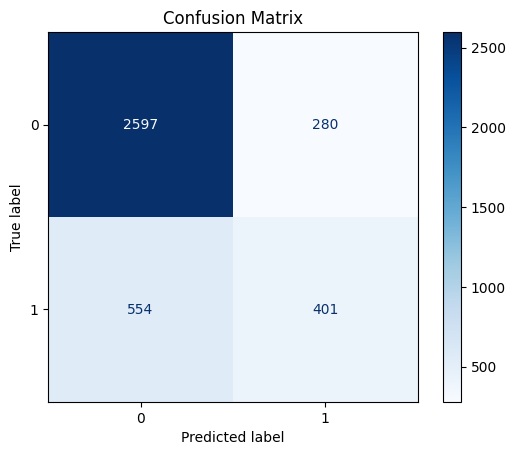

In [39]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [40]:
#Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(n_jobs=-1, random_state=42, class_weight='balanced')
rf.fit(X_train,y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

In [41]:
y_pred=rf.predict(X_test)
print("Accuracy Score:",accuracy_score(y_test,y_pred))
print('Roc Auc Score:',roc_auc_score(y_test, y_pred))

Accuracy Score: 0.7364300626304802
Roc Auc Score: 0.696105054166735


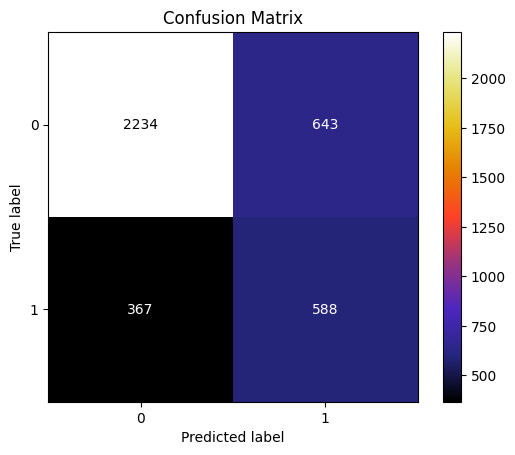

In [42]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='CMRmap')
plt.title('Confusion Matrix')
plt.show()

In [43]:
#KNeighborsClassifier
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Roc Auc Score",roc_auc_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7437369519832986
Roc Auc Score 0.6247217960826705
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.86      0.83      2877
           1       0.48      0.39      0.43       955

    accuracy                           0.74      3832
   macro avg       0.65      0.62      0.63      3832
weighted avg       0.73      0.74      0.73      3832



**Hyper Parameter Tuning(HPT)**

In [44]:
#HPT of Logistic Regression
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2']
}
grid = GridSearchCV(estimator=lr, 
                           param_grid=param_grid_lr, 
                           cv=5, 
                           n_jobs=-1, 
                           verbose=2)
grid.fit(X_train,y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10], 'penalty': ['l2']},
             verbose=2)

In [45]:
best_model = grid.best_estimator_
print(best_model)

LogisticRegression(C=1)


In [46]:
y_pred = best_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Roc Auc Score",roc_auc_score(y_test, y_pred))
print("Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7823590814196242
Roc Auc Score 0.6556895544551753
Report:
               precision    recall  f1-score   support

           0       0.82      0.91      0.86      2877
           1       0.59      0.40      0.48       955

    accuracy                           0.78      3832
   macro avg       0.71      0.66      0.67      3832
weighted avg       0.76      0.78      0.77      3832



In [47]:
#HPT of Random Forest 
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}


grid_search = GridSearchCV(estimator=rf, 
                           param_grid=param_grid, 
                           cv=5, 
                           n_jobs=-1, 
                           verbose=2)


grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV] END .................................C=0.01, penalty=l2; total time=   0.1s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.1s
[CV] END ..................................C=0.1, penalty=l2; total time=   0.1s
[CV] END ....................................C=1, penalty=l2; total time=   0.2s
[CV] END ...................................C=10, penalty=l2; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   2.9s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   3.0s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   5.9s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   2.6s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1,

In [48]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Roc Auc Score",roc_auc_score(y_test, y_pred))
print("Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7364300626304802
Roc Auc Score 0.696105054166735
Report:
               precision    recall  f1-score   support

           0       0.86      0.78      0.82      2877
           1       0.48      0.62      0.54       955

    accuracy                           0.74      3832
   macro avg       0.67      0.70      0.68      3832
weighted avg       0.76      0.74      0.75      3832



In [49]:
param_grid_svc = {
        'C': [0.1, 1, 10],
        'kernel': ['rbf', 'linear'],
        'gamma': ['scale', 'auto']
    }
grid_svc = GridSearchCV(estimator=sc, 
                           param_grid=param_grid_svc, 
                           cv=5, 
                           n_jobs=-1, 
                           verbose=2)


grid_svc.fit(X_train, y_train)
print("Best Parameters:", grid_svc.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}


In [50]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Roc Auc Score",roc_auc_score(y_test, y_pred))
print("Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7364300626304802
Roc Auc Score 0.696105054166735
Report:
               precision    recall  f1-score   support

           0       0.86      0.78      0.82      2877
           1       0.48      0.62      0.54       955

    accuracy                           0.74      3832
   macro avg       0.67      0.70      0.68      3832
weighted avg       0.76      0.74      0.75      3832

